In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

from IPython.core.debugger import set_trace

In [2]:
import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [4]:
import datasets, models

/analysis/share/johannesr/torchsample/torchsample/modules/_utils.py:8: UserWarning: inspect.signature not available... you should upgrade to Python 3.x
  warnings.warn('inspect.signature not available... '


# Load data

In [5]:
# TODO: Describe here where the dataset needs to be stored, i.e. which table, which images and directory structure of the images.
# TODO: Maybe write filepaths here.

In [5]:
# Load the data table with all 1.5 Tesla MRI scans from ADNI.
df = datasets.load_data_table_15T()

Loading dataframe for /analysis/share/ADNI/ADNI_tables/customized/DxByImgClean_CompleteAnnual2YearVisitList_1_5T.csv
Found 1590 images in table
Filtered out 2 of 1590 images because of failed preprocessing
Filtered out 0 of 1588 images because of missing files
Filtered out 619 of 1588 images that were MCI
Final dataframe contains 969 images from 344 patients



Let's look at the table. Each row is a single MRI image. Some important columns in the table:

- PTID: Patient ID
- VISCODE: Visit code (bl=baseline, mx=after x months) (see also Visit)
- DX: Diagnosis (CN=control, MCI=mild cognitive impairment, Dementia=Alzheimer's disease)
- Image.ID: Image ID
- filepath: The path to the MRI image (not contained in the original ADNI table but added by `datasets.load_data_table()`

In [7]:
df.head()

,RID,PTID,VISCODE,DX,EXAMDATE,Image.ID,Scan.Date,Sequence,Visit,Month_bl,Screen.Diagnosis,Study.ID,Series.ID,label_three_fold,label_CN_AD,label_CN_MCI,label_MCI_AD,filepath
0,3,011_S_0003,bl,Dementia,2005-09-12,32237,9/1/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0.0000,AD,1948,9127,2,1.0,NaN,1.0,/analysis/share/ADNI/ADNI_2Yr_15T_quick_prepro...
1,3,011_S_0003,m12,Dementia,2006-09-12,35576,9/12/06,MPR; GradWarp; B1 Correction; N3; Scaled,Month 12,11.9672,AD,5186,19096,2,1.0,NaN,1.0,/analysis/share/ADNI/ADNI_2Yr_15T_quick_prepro...
2,3,011_S_0003,m24,Dementia,2007-09-12,88252,9/12/07,MPR; GradWarp; B1 Correction; N3; Scaled,Month 24,23.9344,AD,11918,39296,2,1.0,NaN,1.0,/analysis/share/ADNI/ADNI_2Yr_15T_quick_prepro...
3,5,011_S_0005,bl,CN,2005-09-07,32246,9/2/05,MPR-R; GradWarp; B1 Correction; N3; Scaled,Screening,0.0000,NL,1950,9136,0,0.0,0.0,NaN,/analysis/share/ADNI/ADNI_2Yr_15T_quick_prepro...
4,5,011_S_0005,m12,CN,2006-09-05,31906,9/5/06,MPR; GradWarp; B1 Correction; N3; Scaled,Month 12,11.9016,NL,5171,19041,0,0.0,0.0,NaN,/analysis/share/ADNI/ADNI_2Yr_15T_quick_prepro...


In [8]:
# Patient-wise train-test-split.
# Select a number of patients for each class, put all their images in the test set 
# and all other images in the train set. This is the split that is used in the paper to produce the heatmaps.
test_patients_per_class = 30

patients_AD = df[df['DX'] == 'Dementia']['PTID'].unique()
patients_CN = df[df['DX'] == 'CN']['PTID'].unique()
patients_CN = filter(lambda p: p not in patients_AD, patients_CN)  # patients that have both a CN and an AD scan should belong to the AD group

patients_AD_train, patients_AD_test = train_test_split(patients_AD, test_size=test_patients_per_class, random_state=0)
patients_CN_train, patients_CN_test = train_test_split(patients_CN, test_size=test_patients_per_class, random_state=0)

patients_train = np.concatenate([patients_AD_train, patients_CN_train])
patients_test = np.concatenate([patients_AD_test, patients_CN_test])

In [9]:
train_dataset, test_dataset = datasets.build_datasets(df, patients_train, patients_test)

         Images    -> AD    -> CN    Patients    -> AD    -> CN
-----  --------  -------  -------  ----------  -------  -------
All         969      475      494         344      193      151
Train       794      399      395         284      163      121
Val         175       76       99          60       30       30

Dataset is not normalized, this could dramatically decrease performance


0.0 599.309794747 None None


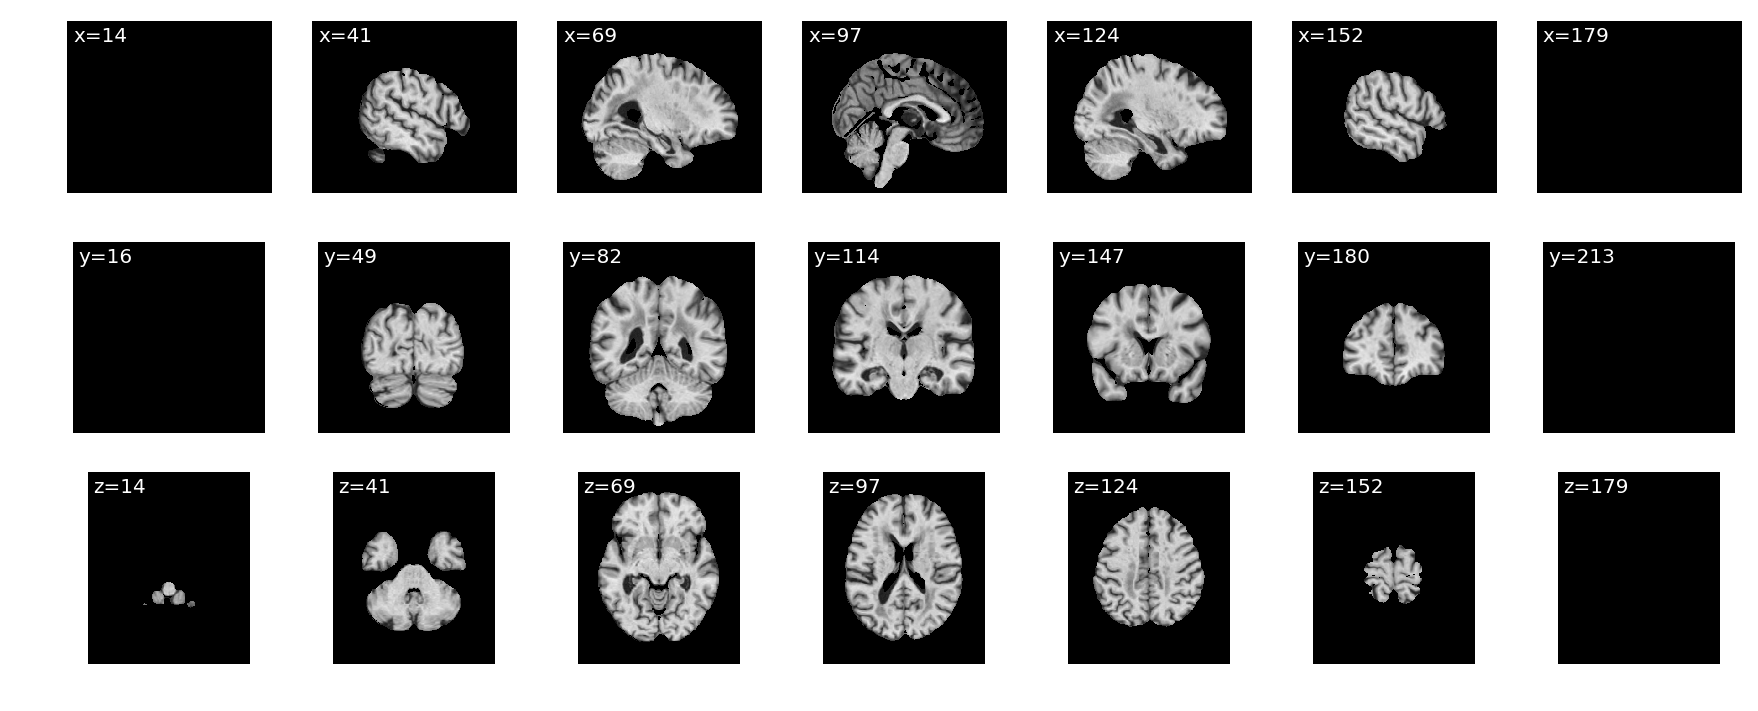

In [21]:
# Plot one MRI scan from the dataset, first without normalization...
i = 0
utils.plot_slices(train_dataset.get_raw_image(i))

-1.86605322361 3.50591540337 None None


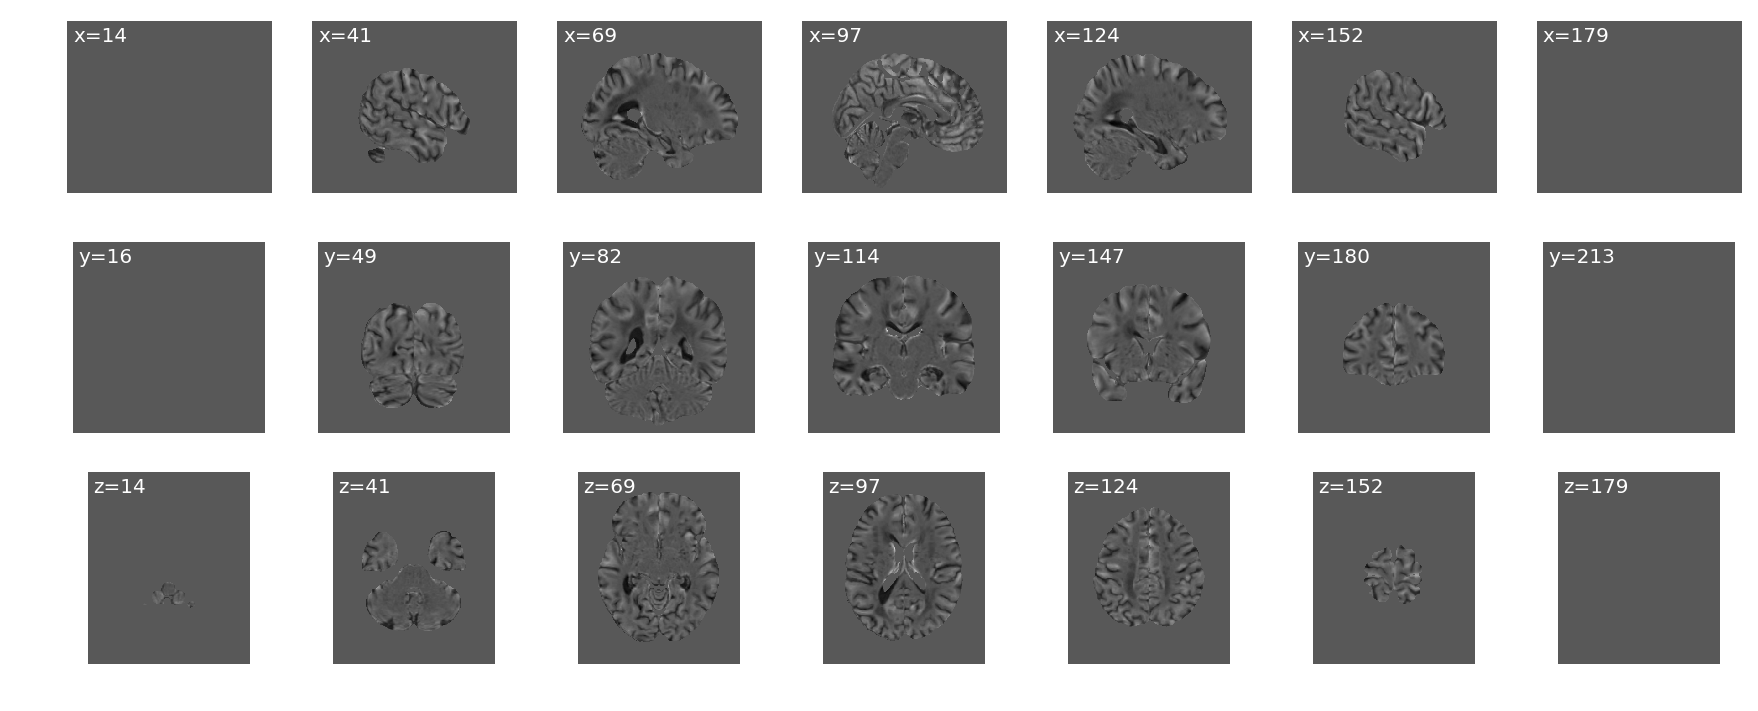

In [22]:
# ... and then with normalization, i.e. the way the network sees it.
utils.plot_slices(train_dataset[i][0][0])

In [ ]:
train_loader, test_loader = datasets.build_loaders(train_dataset, test_dataset)

# Create model and train

In [24]:
# This creates the model from the paper in pytorch, and wraps it in a `trainer` via torchsample. 
net, trainer, cuda_device = models.build_model()

Moved network to GPU


In [ ]:
models.train_model(trainer, train_loader, test_loader, cuda_device, num_epoch=10)

Epoch 1/10:   1%|          | 1/158 [00:00<00:51,  3.02 batches/s]models.py:196: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return super(CategoricalAccuracyWithLogits, self).__call__(F.softmax(y_pred), y_true)
Epoch 1/10: : 159 batches [07:22, 25.74s/ batches, acc_metric=50.5118, loss=0.7050, val_acc_metric=51.4286, val_loss=0.6732]                 
Epoch 2/10:  37%|███▋      | 59/158 [02:00<02:52,  1.74s/ batches, acc_metric=48.6428, loss=0.6960]Process Process-18:
Process Process-22:
Process Process-21:
Traceback (most recent call last):
Process Process-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/johannesr/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/johannesr/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-24:
Process Process-19:
Process Process-23:
Process Process-17:
  F

    raw_data = self.get_unscaled()
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/nibabel/arrayproxy.py", line 285, in get_unscaled
    self._read(readsize)
    return array(a, dtype, copy=False, order=order, subok=True)
  File "/home/johannesr/anaconda2/lib/python2.7/gzip.py", line 308, in _read
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/nibabel/arrayproxy.py", line 290, in __array__
    mmap=self._mmap)
    buf = self.fileobj.read(size)
KeyboardInterrupt
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/nibabel/volumeutils.py", line 524, in array_from_file
    raw_data = self.get_unscaled()
    n_read = infile.readinto(data_bytes)
  File "/home/johannesr/anaconda2/lib/python2.7/gzip.py", line 268, in read
    self._read(readsize)
  File "/home/johannesr/anaconda2/lib/python2.7/site-packages/nibabel/arrayproxy.py", line 285, in get_unscaled
  File "/home/johannesr/anaconda2/lib/python2.7/gzip.py", line 308, in _read
    mmap=self._mmap)
  

In [ ]:
# TODO: Train network to end and check that this works.
utils.plot_learning_curve(trainer.history)

In [ ]:
models.calculate_roc_auc(trainer, val_loader, cuda_device)

# Save/load model

In [40]:
#torch.save(net, 'output/models/softmax-output.pt')
#torch.save(net.state_dict(), 'output/models/softmax-output_state-dict.pt')

/home/johannesr/anaconda2/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type ClassificationModel3D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
net = models.ClassificationModel3D()
net.load_state_dict(torch.load('output/models/softmax-output_state-dict.pt'))

In [22]:
if torch.cuda.is_available():
    net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

Moved network to GPU


# K-Fold Cross Validation

In [ ]:
# This is used to report the accuracy and ROC in the paper. 
# We take the metrics on the test fold after 20 epochs, regardless of how good they are or if they've been better during an earlier epoch. 

from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

patients_all = df['PTID'].unique()

normalize = True
num_epoch = 20

# Split patients into k folds.
for i, (indices_train, indices_test) in enumerate(kfold.split(patients_all)):
    print('{}-fold CV - Split {}:'.format(kfold.n_splits, i+1))
    print()

    print('Preparing datasets...')
    patients_train, patients_test = patients_all[indices_train], patients_all[indices_test]
    train_dataset, test_dataset = datasets.build_datasets(df, patients_train, patients_test, normalize=normalize)
    train_loader, test_loader = datasets.build_loaders(train_dataset, test_dataset)
    
    print('Building model and trainer...')
    net, trainer, cuda_device = models.build_model()
    
    print('Starting training...')
    models.train_model(trainer, train_loader, test_loader, cuda_device, num_epoch=num_epoch)

    utils.plot_learning_curve(trainer.history)
    
    print('Evaluating ROC...')
    roc_auc = models.calculate_roc_auc(trainer, test_loader, cuda_device)
    print('ROC AUC:', roc_auc)

    print()
    print('-'*80)
    print()


5-fold CV - Split 1:

Preparing datasets...
         Images    -> AD    -> CN    Patients    -> AD    -> CN
-----  --------  -------  -------  ----------  -------  -------
All         969      475      494         344      193      151
Train       774      388      386         275      159      116
Val         195       87      108          69       34       35

Calculating mean and std for normalization:


A Jupyter Widget


Building model and trainer...


Epoch 1/20:   0%|          | 0/154 [00:00<?, ? batches/s]

Moved network to GPU
Starting training...


Epoch 1/20:   1%|          | 1/154 [00:00<00:42,  3.58 batches/s]models.py:196: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return super(CategoricalAccuracyWithLogits, self).__call__(F.softmax(y_pred), y_true)
Epoch 1/20: : 155 batches [06:55, 28.30s/ batches, acc_metric=50.0323, loss=0.6978, val_acc_metric=44.6154, val_loss=0.6791]                 
Epoch 2/20: : 155 batches [07:04, 28.71s/ batches, acc_metric=53.8234, loss=0.6960, val_acc_metric=44.6154, val_loss=0.6912]                 
Epoch 3/20:   6%|▌         | 9/154 [00:21<02:20,  1.03 batches/s, acc_metric=70.9196, loss=0.6604]

Building model and trainer...


Epoch 1/20:   0%|          | 0/154 [00:00<?, ? batches/s]

Moved network to GPU
Starting training...


Epoch 1/20: : 155 batches [07:14, 27.51s/ batches, acc_metric=48.0335, loss=0.7001, val_acc_metric=52.3077, val_loss=0.6660]                 
Epoch 2/20: : 155 batches [06:44, 27.15s/ batches, acc_metric=50.3172, loss=0.6930, val_acc_metric=61.5385, val_loss=0.6470]                 
Epoch 3/20: : 155 batches [06:48, 32.22s/ batches, acc_metric=57.2904, loss=0.6862, val_acc_metric=60.5128, val_loss=0.6550]                 
Epoch 4/20: : 155 batches [07:24, 32.36s/ batches, acc_metric=57.6589, loss=0.6821, val_acc_metric=60.5128, val_loss=0.6517]                 
Epoch 5/20:  51%|█████▏    | 79/154 [02:45<02:02,  1.63s/ batches, acc_metric=62.4343, loss=0.6556]